# Kelompok 18

Muhammad Naufal Hawari (1301213069)

Versa Syahputra Santo (1301213373)

# Setup Library dan Data

In [1]:
# Setup library
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import joblib  # For saving the best model

from skimage.feature import BRIEF
import warnings
warnings.filterwarnings('ignore')

from PIL import Image

In [2]:
# Load train dan test 
train_df = pd.read_csv('/kaggle/input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv')
test_df = pd.read_csv('/kaggle/input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv')

# Split citra (X) dan label (y)
X_train = train_df.drop('label', axis=1).values.reshape(-1, 28, 28).astype(np.uint8)
y_train = train_df['label'].values

X_test = test_df.drop('label', axis=1).values.reshape(-1, 28, 28).astype(np.uint8)
y_test = test_df['label'].values


# Setup Fungsi untuk Preprocessing dan Training

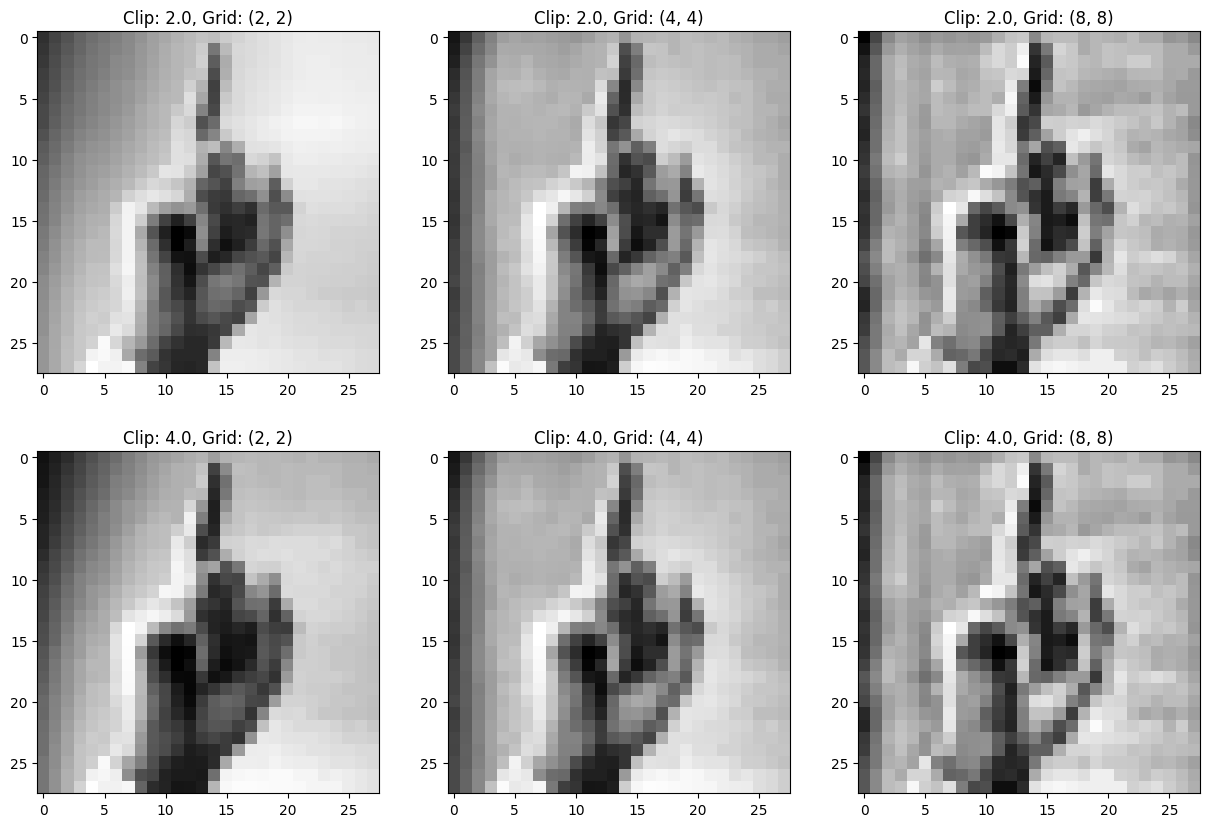

In [3]:
def apply_clahe(image, clip_limit=2.0, grid_size=(8, 8)):
    
    # Menerapkan CLAHE dengan parameter clip limit dan grid size
    
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=grid_size)
    return clahe.apply(image)


def visualize_clahe(image):

    # Visualisasi CLAHE terhadap citra
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    params = [(2.0, (2, 2)), (2.0, (4, 4)), (2.0, (8, 8)), (4.0, (2, 2)), (4.0, (4, 4)), (4.0, (8, 8))]
    for i, (clip, grid) in enumerate(params):
        clahe_img = apply_clahe(image, clip, grid)
        ax = axes[i // 3, i % 3]
        ax.imshow(clahe_img, cmap='gray')
        ax.set_title(f'Clip: {clip}, Grid: {grid}')
    plt.show()

# Contoh visualisasi
visualize_clahe(X_train[0])

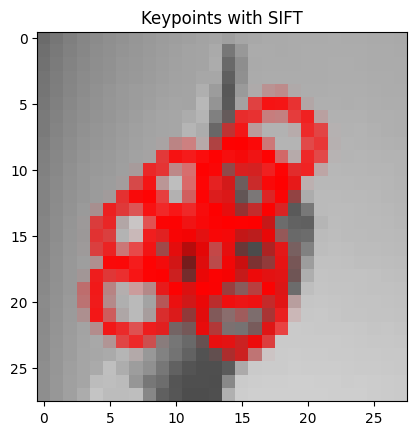

In [18]:
# Cell 4: Feature Extraction Methods
def extract_features(image, method='SIFT'):

    # Fungsi untuk ekstraksi fitur SIFT dan FAST
    
    if method == 'SIFT':
        sift = cv2.SIFT_create()
        keypoints, descriptors = sift.detectAndCompute(image, None)
    elif method == 'FAST':
        fast = cv2.FastFeatureDetector_create()
        keypoints = fast.detect(image, None)
        descriptors = np.array([kp.pt for kp in keypoints])
    else:
        raise ValueError('Unknown feature extraction method.')
    return keypoints, descriptors


from sklearn.cluster import KMeans
from tqdm import tqdm

def create_bovw(descriptors_list, num_clusters=150):

    # Fungsi untuk membuat bag of visual words dengan k-means clustering
    
    all_descriptors = np.vstack([d for d in descriptors_list if d is not None])
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(all_descriptors)
    
    histograms = []
    for descriptors in tqdm(descriptors_list):
        histogram = np.zeros(num_clusters)
        if descriptors is not None:
            labels = kmeans.predict(descriptors)
            for label in labels:
                histogram[label] += 1
        histograms.append(histogram)
    
    return np.array(histograms)

def preprocess_and_extract_features(X, clip_limit=2.0, grid_size=(8, 8), method=None):
    
    # Fungsi pipeline dari CLAHE hingga bag of visual words
    
    descriptors_list = []
    for img in X:
        if clip_limit != 0:
            img = apply_clahe(img, clip_limit=clip_limit, grid_size=grid_size)
        _, descriptors = extract_features(img, method) if method else (None, img.flatten())
        descriptors_list.append(descriptors)
    return descriptors_list

def visualize_keypoints(image, method='SIFT'):

    # Visualisasi keypoints dari ekstraksi fitur tertentu
    
    keypoints, _ = extract_features(image, method)
    img_with_keypoints = cv2.drawKeypoints(image, keypoints, None, color=(255, 0, 0))
    plt.imshow(img_with_keypoints, cmap='gray')
    plt.title(f'Keypoints with {method}')
    plt.show()

# Contoh visualisasi keypoint
visualize_keypoints(X_train[0], method='SIFT')

In [6]:
def train_evaluate_model(X_train, X_test, y_train, y_test, model, model_name, feature_method=None):

    # Fungsi pipeline untuk train dan evaluasi model
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    
    return {
        'model': model_name,
        'feature_method': feature_method,
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Eksperimen

In [7]:
# Eksperimen 3 model dengan 3 metode ekstraksi fitur (total 9 eksperimen)
models = {
    'LogisticRegression': LogisticRegression(),
    'SVM': SVC(),
    'LightGBM': LGBMClassifier(verbosity=-1),
}

feature_methods = ['None', 'SIFT', 'FAST']

results = []

for method in feature_methods:
    print(f"Processing feature extraction: {method}")
    
    descriptors_train = preprocess_and_extract_features(X_train, method=method if method != 'None' else None)
    descriptors_test = preprocess_and_extract_features(X_test, method=method if method != 'None' else None)
    
    # Create BOVW
    if method != 'None':
        X_train_bovw = create_bovw(descriptors_train)
        X_test_bovw = create_bovw(descriptors_test)
    else:
        X_train_bovw = np.array(descriptors_train)
        X_test_bovw = np.array(descriptors_test)
    for model_name, model in models.items():
        print(f"Training model {model_name} with features {method}")
        result = train_evaluate_model(X_train_bovw, X_test_bovw, y_train, y_test, model, model_name, method)
        print(f"F1-score: {result['f1']}")
        results.append(result)

Processing feature extraction: None


extracting features...: 100%|██████████| 7172/7172 [00:00<00:00, 16092.13it/s]


Training model LogisticRegression with features None
F1-score: 0.6440462411807364
Training model SVM with features None
F1-score: 0.8011116480706849
Training model LightGBM with features None
F1-score: 0.6990199116280534
Processing feature extraction: SIFT


100%|██████████| 7172/7172 [00:01<00:00, 3821.72it/s]


Training model LogisticRegression with features SIFT
F1-score: 0.03776534320972117
Training model SVM with features SIFT
F1-score: 0.04093525463344289
Training model LightGBM with features SIFT
F1-score: 0.04436465631345508
Processing feature extraction: FAST


100%|██████████| 7172/7172 [00:01<00:00, 4221.61it/s]


Training model LogisticRegression with features FAST
F1-score: 0.03739866725093532
Training model SVM with features FAST
F1-score: 0.03422916068551502
Training model LightGBM with features FAST
F1-score: 0.03498813145480905


In [ ]:
# Simpan hasil eksperimen
results_df = pd.DataFrame(results)
results_df.to_csv('experiment_results.csv', index=False)

In [9]:
results_df

,model,feature_method,accuracy,f1,precision,recall
0,LogisticRegression,None,0.664250,0.644046,0.663160,0.649546
1,SVM,None,0.816927,0.801112,0.815270,0.808911
2,LightGBM,None,0.719883,0.699020,0.714261,0.713345
3,LogisticRegression,SIFT,0.039598,0.037765,0.038808,0.041840
4,SVM,SIFT,0.042945,0.040935,0.041637,0.045614
5,LightGBM,SIFT,0.046431,0.044365,0.045696,0.049769
6,LogisticRegression,FAST,0.040853,0.037399,0.045640,0.040655
7,SVM,FAST,0.037228,0.034229,0.043599,0.037750
8,LightGBM,FAST,0.037646,0.034988,0.037589,0.042965


In [ ]:
results = []

In [13]:
# Eksperimen parameter CLAHE terhadap performa model

def get_model(name):
    models = {
        'LogisticRegression': LogisticRegression(),
        'SVM': SVC(),
        'LightGBM': LGBMClassifier(verbosity=-1),
    }

    return models[name]

results = []

for model_name in ['LogisticRegression', 'SVM', 'LightGBM']:
    for clip_limit in [2, 4, 8]:
        for grid_size in [2, 4, 8]:

            descriptors_train = preprocess_and_extract_features(X_train, float(clip_limit), (grid_size, grid_size), None)
            descriptors_test = preprocess_and_extract_features(X_test, float(clip_limit), (grid_size, grid_size), None)
            
            X_train_bovw = np.array(descriptors_train)
            X_test_bovw = np.array(descriptors_test)

            model = get_model(model_name)
            
            print(f"Training model {model_name} with clip limit = {clip_limit}, grid size = {grid_size}, F1-score: {result['f1']}")
            result = train_evaluate_model(X_train_bovw, X_test_bovw, y_train, y_test, model, model_name, None)
            result['clip_limit'] = clip_limit
            result['grid_size'] = grid_size
            # print(f"F1-score: {result['f1']}")
            results.append(result)

Training model LogisticRegression with clip limit = 2, grid size = 2, F1-score: 0.6571373333807143
Training model LogisticRegression with clip limit = 2, grid size = 4, F1-score: 0.6162292883384106
Training model LogisticRegression with clip limit = 2, grid size = 8, F1-score: 0.6810670419835438
Training model LogisticRegression with clip limit = 4, grid size = 2, F1-score: 0.6440462411807364
Training model LogisticRegression with clip limit = 4, grid size = 4, F1-score: 0.6419002318867534
Training model LogisticRegression with clip limit = 4, grid size = 8, F1-score: 0.6810670419835438
Training model LogisticRegression with clip limit = 8, grid size = 2, F1-score: 0.6440462411807364
Training model LogisticRegression with clip limit = 8, grid size = 4, F1-score: 0.643379807963056
Training model LogisticRegression with clip limit = 8, grid size = 8, F1-score: 0.6810670419835438
Training model SVM with clip limit = 2, grid size = 2, F1-score: 0.6440462411807364
Training model SVM with cl

In [14]:
# Simpan hasil eksperimen
results_df = pd.DataFrame(results)
results_df.to_csv('experiment_results.csv', index=False)

In [15]:
# Melihat hasil eksperimen berbagai parameter CLAHE
results_df

,model,feature_method,accuracy,f1,precision,recall,clip_limit,grid_size
0,LogisticRegression,None,0.639849,0.616229,0.632062,0.624102,2,2
1,LogisticRegression,None,0.700641,0.681067,0.698406,0.684321,2,4
2,LogisticRegression,None,0.664250,0.644046,0.663160,0.649546,2,8
3,LogisticRegression,None,0.671640,0.641900,0.654537,0.651710,4,2
4,LogisticRegression,None,0.700641,0.681067,0.698406,0.684321,4,4
5,LogisticRegression,None,0.664250,0.644046,0.663160,0.649546,4,8
6,LogisticRegression,None,0.669548,0.643380,0.655620,0.652306,8,2
7,LogisticRegression,None,0.700641,0.681067,0.698406,0.684321,8,4
8,LogisticRegression,None,0.664250,0.644046,0.663160,0.649546,8,8
9,SVM,None,0.846905,0.831617,0.836285,0.838232,2,2


In [19]:
# Eksperimen tanpa CLAHE

def get_model(name):
    models = {
        'LogisticRegression': LogisticRegression(),
        'SVM': SVC(),
        'LightGBM': LGBMClassifier(verbosity=-1),
    }

    return models[name]


for model_name in ['LogisticRegression', 'SVM', 'LightGBM']:
    clip_limit = 0
    grid_size = 0

    descriptors_train = preprocess_and_extract_features(X_train, float(clip_limit), (grid_size, grid_size), None)
    descriptors_test = preprocess_and_extract_features(X_test, float(clip_limit), (grid_size, grid_size), None)
    
    X_train_bovw = np.array(descriptors_train)
    X_test_bovw = np.array(descriptors_test)

    model = get_model(model_name)
    
    print(f"Training model {model_name} with clip limit = {clip_limit}, grid size = {grid_size}, F1-score: {result['f1']}")
    result = train_evaluate_model(X_train_bovw, X_test_bovw, y_train, y_test, model, model_name, None)
    result['clip_limit'] = clip_limit
    result['grid_size'] = grid_size
    # print(f"F1-score: {result['f1']}")
    results.append(result)

Training model LogisticRegression with clip limit = 0, grid size = 0, F1-score: 0.6990199116280534
Training model SVM with clip limit = 0, grid size = 0, F1-score: 0.6319313056544258
Training model LightGBM with clip limit = 0, grid size = 0, F1-score: 0.8255212881989028


In [20]:
# Simpan dan lihat hasil eksperimen tanpa CLAHE

results_df = pd.DataFrame(results)
results_df.to_csv('experiment_results_2.csv', index=False)
results_df

,model,feature_method,accuracy,f1,precision,recall,clip_limit,grid_size
0,LogisticRegression,None,0.639849,0.616229,0.632062,0.624102,2,2
1,LogisticRegression,None,0.700641,0.681067,0.698406,0.684321,2,4
2,LogisticRegression,None,0.664250,0.644046,0.663160,0.649546,2,8
3,LogisticRegression,None,0.671640,0.641900,0.654537,0.651710,4,2
4,LogisticRegression,None,0.700641,0.681067,0.698406,0.684321,4,4
5,LogisticRegression,None,0.664250,0.644046,0.663160,0.649546,4,8
6,LogisticRegression,None,0.669548,0.643380,0.655620,0.652306,8,2
7,LogisticRegression,None,0.700641,0.681067,0.698406,0.684321,8,4
8,LogisticRegression,None,0.664250,0.644046,0.663160,0.649546,8,8
9,SVM,None,0.846905,0.831617,0.836285,0.838232,2,2


In [27]:
# Eksperimen hyperparameter tuning LGBM

clip_limit = 0
grid_size = 0
model_name = 'LightGBM'

descriptors_train = preprocess_and_extract_features(X_train, float(clip_limit), (grid_size, grid_size), None)
descriptors_test = preprocess_and_extract_features(X_test, float(clip_limit), (grid_size, grid_size), None)


results_tuning = []
for max_depth in range(3, 16):
    
    X_train_bovw = np.array(descriptors_train)
    X_test_bovw = np.array(descriptors_test)
    
    model = LGBMClassifier(max_depth=max_depth, verbosity=-1)
    # print(f"Training model {model_name} with clip limit = {clip_limit}, grid size = {grid_size}")
    result = train_evaluate_model(X_train_bovw, X_test_bovw, y_train, y_test, model, model_name, None)
    result['max_depth'] = max_depth
    print('max_depth', max_depth, ', f1:', result['f1'], ', akurasi:', result['accuracy'])

    results_tuning.append(result)
    
    # joblib.dump(model, f'tubes-pcd-{model_name}.pkl')

max_depth 3 , f1: 0.7147195480028744 , akurasi: 0.7346625766871165
max_depth 4 , f1: 0.7459724122668702 , akurasi: 0.7658951477969883
max_depth 5 , f1: 0.7602384871290856 , akurasi: 0.7771890686001115
max_depth 6 , f1: 0.7743547727305472 , akurasi: 0.7891801450083659
max_depth 7 , f1: 0.7726968474580391 , akurasi: 0.7900167317345231
max_depth 8 , f1: 0.776040349189829 , akurasi: 0.7933630786391522
max_depth 9 , f1: 0.780099638715821 , akurasi: 0.7979643056330172
max_depth 10 , f1: 0.7830531206877192 , akurasi: 0.8007529280535416
max_depth 11 , f1: 0.7792863509322164 , akurasi: 0.7967094255437813
max_depth 12 , f1: 0.7707476074617228 , akurasi: 0.7891801450083659
max_depth 13 , f1: 0.77346850760491 , akurasi: 0.7911321807027328
max_depth 14 , f1: 0.7743796368995645 , akurasi: 0.7909927495817066
max_depth 15 , f1: 0.778078295752317 , akurasi: 0.7965699944227551


In [29]:
# Eksperimen hyperparameter tuning SVM

clip_limit = 8
grid_size = 2

results_tuning_svm = []
for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    descriptors_train = preprocess_and_extract_features(X_train, float(clip_limit), (grid_size, grid_size), None)
    descriptors_test = preprocess_and_extract_features(X_test, float(clip_limit), (grid_size, grid_size), None)
    
    X_train_bovw = np.array(descriptors_train)
    X_test_bovw = np.array(descriptors_test)
    
    model = SVC(kernel=kernel)
    
    # print(f"Training model {model_name} with clip limit = {clip_limit}, grid size = {grid_size}")
    result = train_evaluate_model(X_train_bovw, X_test_bovw, y_train, y_test, model, 'SVM', None)
    result['kernel'] = kernel
    print('kernel', kernel, ', f1:', result['f1'], ', akurasi:', result['accuracy'])

    results_tuning_svm.append(result)
    
    # joblib.dump(model, f'tubes-pcd-{model_name}.pkl')

kernel linear , f1: 0.7748943561114515 , akurasi: 0.7961517010596765
kernel poly , f1: 0.8237419297965696 , akurasi: 0.8430005577244841
kernel rbf , f1: 0.8527513583437928 , akurasi: 0.8661461238148355
kernel sigmoid , f1: 0.016718478215311142 , akurasi: 0.05674846625766871


In [ ]:
# Menyimpan model SVM dengan skema terbaik untuk aplikasi

clip_limit = 8
grid_size = 2
model_name = 'SVM'

descriptors_train = preprocess_and_extract_features(X_train, float(clip_limit), (grid_size, grid_size), None)
descriptors_test = preprocess_and_extract_features(X_test, float(clip_limit), (grid_size, grid_size), None)

X_train_bovw = np.array(descriptors_train)
X_test_bovw = np.array(descriptors_test)

model = get_model(model_name)

# print(f"Training model {model_name} with clip limit = {clip_limit}, grid size = {grid_size}")
result = train_evaluate_model(X_train_bovw, X_test_bovw, y_train, y_test, model, model_name, None)

joblib.dump(model, f'tubes-pcd-{model_name}.pkl')

In [23]:
# Menyimpan model LGBM dengan skema terbaik untuk aplikasi

clip_limit = 0
grid_size = 0
model_name = 'LightGBM'

descriptors_train = preprocess_and_extract_features(X_train, float(clip_limit), (grid_size, grid_size), None)
descriptors_test = preprocess_and_extract_features(X_test, float(clip_limit), (grid_size, grid_size), None)

X_train_bovw = np.array(descriptors_train)
X_test_bovw = np.array(descriptors_test)

model = get_model(model_name)

# print(f"Training model {model_name} with clip limit = {clip_limit}, grid size = {grid_size}")
result = train_evaluate_model(X_train_bovw, X_test_bovw, y_train, y_test, model, model_name, None)

joblib.dump(model, f'tubes-pcd-{model_name}.pkl')

['tubes-pcd-LightGBM.pkl']

# Membuat contoh pipeline prediksi untuk aplikasi

In [49]:
# Sampling gambar untuk contoh prediksi dari aplikasi
Image.fromarray(X_test_bovw[7].reshape(28, 28)).save('test.jpg')

In [42]:
# Load model
lgbm_model = joblib.load('/kaggle/working/tubes-pcd-LightGBM.pkl')
svm_model = joblib.load('/kaggle/working/tubes-pcd-SVM.pkl')

def apply_clahe(image, clip_limit=2.0, grid_size=(8, 8)):
    
    # Fungsi implementasi CLAHE
    
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=grid_size)
    return clahe.apply(image)

def model_prediction(uploaded_image, model_name, use_clahe=True):

    '''
    Pipeline prediksi model untuk aplikasi
    
    uploaded_image: str = image path
    model_name: str = lgbm or svm
    use_clahe: bool = either or not using clahe
    '''

    # CLAHE preprocessing
    img = Image.open(uploaded_image)
    img = img.resize((28, 28))
    img = np.array(img)
    if use_clahe:
        img = apply_clahe(img, clip_limit=8.0, grid_size=(2, 2))
    descriptors = img.flatten()

    # # BOVW or flatten
    # if feature_method != 'None':
    #     histograms = []
    #     histogram = np.zeros(num_clusters)
    #     if descriptors is not None:
    #         labels = kmeans.predict(descriptors)
    #         for label in labels:
    #             histogram[label] += 1
    #     histograms.append(histogram)
    #     descriptors = descriptors.reshape(1, -1) 
    # else:
    
    descriptors = np.array(descriptors).reshape(1, -1)

    if model_name == 'lgbm':
        model = lgbm_model
    elif model_name == 'svm':
        model = svm_model
    # elif model_name == 'logistic':
    #     model = joblib.load('tubes-pdc-LogisticRegression.pkl')
    # model = joblib.load(model_path)
    prediction = model.predict(descriptors)
    
    return prediction

In [50]:
# Contoh hasil pipeline prediksi
model_prediction('/kaggle/working/test.jpg', model_name='lgbm', use_clahe=False)

array([14])